# Chapter 17 制約付き最小二乗法の応用

## 17.1 ポートフォリオ最適化

### 複利計算のポートフォリオの評価額

リターンの時系列ベクトル$r$から得られるポートフォリオの累積値は，
一般的な値である10000ドルから始まるとすると，以下の時系列ベクトル$v$で計算できる．
$$
v_t = 10000 (1 + r_1) \cdots (1 + r_{t-1}), \quad t = 1,\ldots, T
$$
言い換えれば，要素が$1+r_t$であるベクトルの総積（cumulative product）である．Juliaにはそのための組み込み関数`cumprod`がある．


In [2]:
# リターンの時系列rに従って再投資するポートフォリオの評価額
cum_value(r) = 10000 * cumprod(1 .+ r);
T = 250;  # 1年間の営業日数
# ランダムなリターン時系列を作成．年換算リターンは10%，年換算リスクは5%
mu = 0.10 / 250;
sigma = 0.05 / sqrt(250);
r = mu .+ sigma * randn(T);
v = cum_value(r);
# 最終的な評価額と平均リターンの比較．
v[T] , v[1]*(1+sum(r))

(11737.769640162292, 11608.932123498449)

In [3]:
using Plots

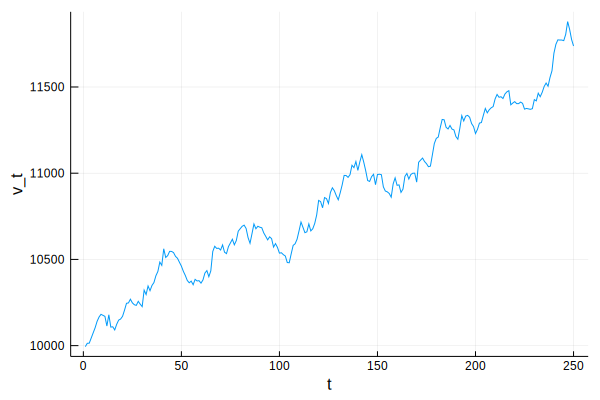

In [5]:
# 1年間の累積評価額をプロット
plot(1:T, v, legend=false)
plot!(xlabel = "t", ylabel = "v_t")

![図17.1](fig17-1.pdf)

図17.1 ポートフォリオの評価額の時間変化


### ポートフォリオ最適化

本書の制約付き最小二乗問題(17.2)の解(17.3)を計算する関数`port_opt`を定義し，本書の17.1.3節のリターンのデータに適用する．


In [6]:
function port_opt(R,rho)
T, n = size(R)
mu = sum(R, dims=1)'/T
KKT = [ 2*R'*R ones(n) mu; ones(n)' 0 0; mu' 0 0]
wz1z2 = KKT \ [2*rho*T*mu; 1; rho]
w = wz1z2[1:n]
return w
end;

In [7]:
using VMLS

In [8]:
R, Rtest = portfolio_data();
T, n = size(R)

(2000, 20)

In [9]:
rho = 0.10/250;  # 年換算リターンは10%
w = port_opt(R, rho);
r = R*w;  # ポートフォリオのリターン時系列
pf_return = 250*avg(r)

0.09999999999999998

In [10]:
pf_risk = sqrt(250)*stdev(r)

0.08650183086854628

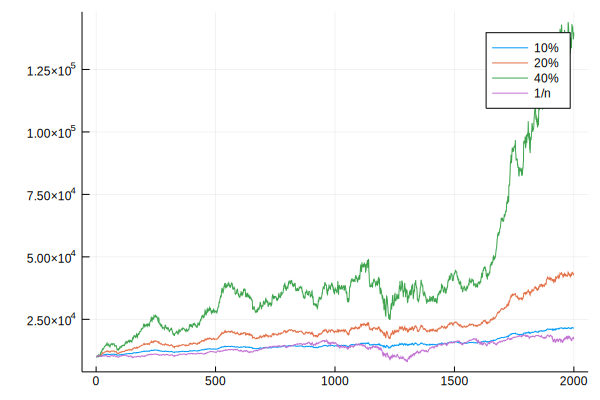

In [11]:
plot(1:T, cum_value(r), label= "10%")
plot!(1:T, cum_value(R*port_opt(R,0.20/250)), label= "20%")
plot!(1:T, cum_value(R*port_opt(R,0.40/250)), label= "40%")
plot!(1:T, cum_value(R*(ones(n)*(1/n))), label= "1/n")

![図17.2](fig17-2.pdf)

図17.2 4つのポートフォリオの時間変化：リターンが10%，20%，40%の場合のパレート最適ポートフォリオ．total valueはdailyリターンの$2000 \times 20$行列$R$を用いて計算した．


このコードの結果は図17.2の「10%」というラベルの付いたカーブである．更に，年換算リターンが20%と40%のものと，$1/n$ポートフォリオ$w = (1/n) \boldsymbol{1}$もプロットしている．





## 17.2 線形二次制御

本書の17.2節で説明している，行列$A, B, C$を持つ時不変系の線形二次制御を実装しよう．

### クロネッカー積

行列$\tilde{A}$と$\tilde{C}$を作成するためには，対角部分に同じ行列を並べたブロック対角行列を定義する必要がある．これを実装する方法はJuliaにはいくつもある．簡単な方法は，2つの行列のクロネッカー積を計算する関数`kron`を使うことである．$m \times n$行列$G$と$p \times q$行列$H$のクロネッカー積は，以下の$mp \times nq$行列である．
$$
\begin{bmatrix}
G_{11} H & G_{12} H & \cdots & G_{1n} H \\
G_{21} H & G_{22} H & \cdots & G_{2n} H \\
\vdots & \vdots & & \vdots \\
G_{m1} H & G_{m2} H & \cdots & G_{mn} H
\end{bmatrix}
$$
Juliaでは`kron(G,H)`とする．もし$G$が$n \times n$単位行列なら，$H$が対角部分に$n$個ならんだブロック対角行列になる．

In [12]:
H = randn(2,2)

2×2 Array{Float64,2}:
 0.560842  1.07037
 0.752419  1.72705

In [13]:
kron(eye(3),H)

6×6 Array{Float64,2}:
 0.560842  1.07037  0.0       0.0      0.0       0.0    
 0.752419  1.72705  0.0       0.0      0.0       0.0    
 0.0       0.0      0.560842  1.07037  0.0       0.0    
 0.0       0.0      0.752419  1.72705  0.0       0.0    
 0.0       0.0      0.0       0.0      0.560842  1.07037
 0.0       0.0      0.0       0.0      0.752419  1.72705

Juliaの関数`cat`を使って以下のようにブロック対角行列を作ることもできる．


In [14]:
cat([H for k=1:3]..., dims=(1,2))

6×6 Array{Float64,2}:
 0.560842  1.07037  0.0       0.0      0.0       0.0    
 0.752419  1.72705  0.0       0.0      0.0       0.0    
 0.0       0.0      0.560842  1.07037  0.0       0.0    
 0.0       0.0      0.752419  1.72705  0.0       0.0    
 0.0       0.0      0.0       0.0      0.560842  1.07037
 0.0       0.0      0.0       0.0      0.752419  1.72705

### 線形二次制御の例

線形二次制御のための制約付き最小二乗問題を解く関数`lqr`を定義する．この関数は以下の3つの配列を返す．

- `x = [ x[1], x[2], ..., x[T] ]`
- `u = [ u[1], u[2], ..., u[T-1] ]`
- `y = [ y[1], y[2], ..., y[T] ]`

最初の2つはこの問題の最適解である．3つ目の配列は$y_t = C x_t$である．

初期状態と終了状態が異なるだけの同じ問題を同時に解くことができるように，
引数`x_init`と`x_des`は行列でもよいことにする．
`x_init`と`x_des`が列数$q$の行列とすると，返り値`x, u, y`も列数$q$の行列になる．
$i$番目の列が，`x_init`と`x_des`の$i$番目の列に対応する解である．

In [15]:
function lqr(A,B,C,x_init,x_des,T,rho)
    n = size(A,1)
    m = size(B,2)
    p = size(C,1)
    q = size(x_init,2)
    Atil = [ kron(eye(T), C)  zeros(p*T,m*(T-1)) ;
             zeros(m*(T-1), n*T)  sqrt(rho)*eye(m*(T-1)) ]
    btil = zeros(p*T + m*(T-1), q)
    # Ctildeをビット毎に作成
    Ctil11 = [ kron(eye(T-1), A) zeros(n*(T-1),n) ]  -
             [ zeros(n*(T-1), n) eye(n*(T-1)) ]
    Ctil12 = kron(eye(T-1), B)
    Ctil21 = [eye(n) zeros(n,n*(T-1));  zeros(n,n*(T-1)) eye(n)]
    Ctil22 = zeros(2*n,m*(T-1))
    Ctil = [Ctil11 Ctil12; Ctil21 Ctil22]
    dtil = [zeros(n*(T-1), q); x_init; x_des]
    z = cls_solve(Atil,btil,Ctil,dtil)
    x = [z[(i-1)*n+1:i*n,:] for i=1:T]
    u = [z[n*T+(i-1)*m+1 : n*T+i*m, :] for i=1:T-1]
    y = [C*xt for xt in x]
    return x, u, y
end;

この関数を本書17.2.1節の例題に適用する．

In [16]:
A = [ 0.855  1.161  0.667;
      0.015  1.073  0.053;
     -0.084  0.059  1.022 ];
B = [-0.076; -0.139; 0.342 ];
C = [ 0.218  -3.597  -1.683 ];
n = 3;
p = 1;
m = 1;
x_init = [0.496; -0.745; 1.394];
x_des = zeros(n,1);

まず本書の図17.4の開ループ応答をプロットする（図17.3）．

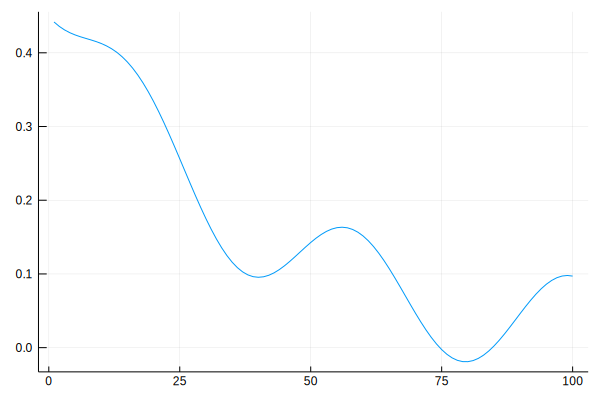

In [18]:
T = 100;
yol = zeros(T,1);
Xol = [ x_init  zeros(n, T-1) ];
for k=1:T-1
    Xol[:,k+1] = A*Xol[:,k];
end;
yol = C*Xol;
using Plots
plot(1:T, yol', legend = false)

![図17.3](fig17-3.pdf)

図17.3 開ループ応答$C A^{t-1} x^\mathrm{init}$



そして$T=100$と$\rho=0.2$について，この線形二次制御問題を解く．その結果が，本書の図17.4の2行目と，図17.4である．

In [19]:
using LinearAlgebra

In [20]:
rho = 0.2;
T = 100;
x, u, y = lqr(A,B,C,x_init,x_des,T,rho);
J_input = norm(u)^2

0.7738942551159881

In [21]:
J_output = norm(y)^2

3.7829986463325063

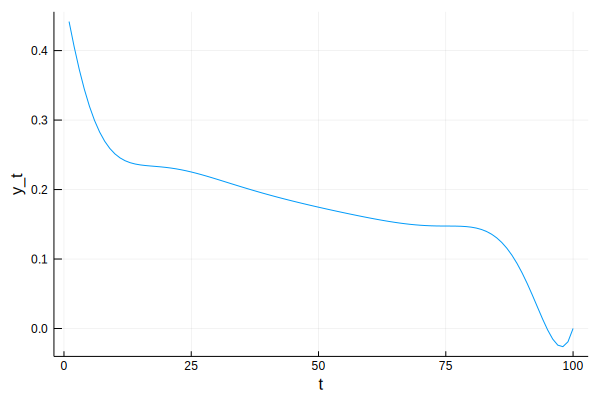

In [24]:
plot(1:T-1, vcat(u...), legend = false, xlabel="t", ylabel= "u_t")
plot(1:T, vcat(y...), legend=false, xlabel = "t", ylabel = "y_t")

![図17.4（上）](fig17-4-1.pdf)
![図17.4（下）](fig17-4-2.pdf)

図17.4 $\rho=0.2$の最適入力と出力




### 線形状態フィードバック制御

最後に本書17.2.3節の状態フィードバック制御を実装する．図17.5は本書の図17.7と同じものである．

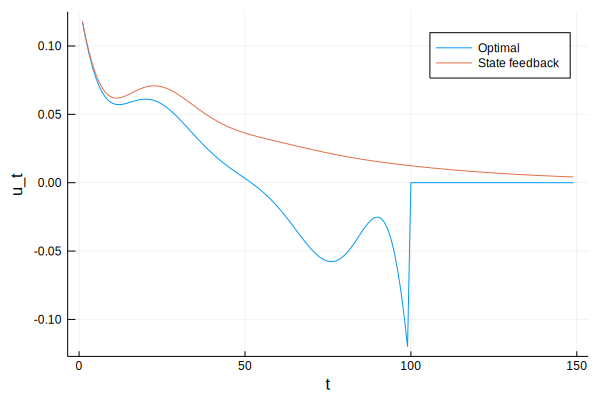

In [26]:
# 線形2次問題をx_init = I, x_des = 0で解く
rho = 1.0;
xsf, usf, ysf = lqr(A,B,C,eye(n),zeros(n,n),T,rho);
K = usf[1];
# 時刻150までしミューレション
TT = 150;
Xsf = [x_init zeros(n,TT-1)];
for k=1:TT-1
    Xsf[:,k+1] = (A+B*K)*Xsf[:,k];
end;
usf = K*Xsf[:, 1:TT-1];
ysf = C*Xsf;
# 最適線形2次問題の解をrho = 1.0についても求める
x, u, y = lqr(A,B,C,x_init,x_des,T,rho);
# 2つの入力をプロット
plot([vcat(u...); zeros(TT-T,1)], label="Optimal", xlabel = "t", ylabel = "u_t")
plot!(usf', label = "State feedback")

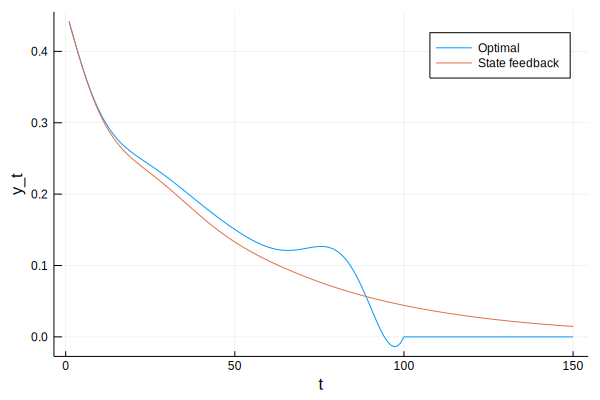

In [27]:
# 2つの出力をプロット
plot_sf_y = plot([vcat(y...); zeros(TT-T,1)], label="Optimal", xlabel = "t", ylabel = "y_t")
plot!(ysf', label = "State feedback")

![図17.5（上）](fig17-5-1.pdf)
![図17.5（下）](fig17-5-2.pdf)

図17.5 $\rho=1$の線形二次制御問題の解（青線）と線形状態フィードバック$u_t = K x_t$の結果の入力と出力（赤線）．



## 17.3 線形二次状態推定

線形二次状態推定のコードは線形二次制御のものとよく似ている．

In [28]:
function lqe(A,B,C,y,T,lambda)
    n = size(A,1)
    m = size(B,2)
    p = size(C,1)
    Atil = [ kron(eye(T), C)  zeros(T*p, m*(T-1));
             zeros(m*(T-1), n*T)  sqrt(lambda)*eye(m*(T-1)) ]
    # yをp x T配列と仮定して，ベクトル化する
    btil = [ vcat(y...) ; zeros((T-1)*m) ]
    Ctil = [ ([ kron(eye(T-1), A) zeros(n*(T-1), n) ] +
              [ zeros(n*(T-1), n) -eye(n*(T-1)) ])  kron(eye(T-1), B) ]
    dtil = zeros(n*(T-1))
    z = cls_solve(Atil, btil, Ctil, dtil)
    x = [ z[(i-1)*n+1:i*n] for i=1:T ]
    u = [ z[n*T+(i-1)*m+1 : n*T+i*m] for i=1:T-1 ]
    y = [ C*xt for xt in x ]
    return x, u, y
end

lqe (generic function with 1 method)

本書17.3.1節の行列を用いる．出力計測データを入力ファイル`estimation_data.jl`から読み込み，$2 \times 100$行列`ymeas`に保存する．$\lambda = 10^3$について解を計算したものが本書の図17.8の左下のプロットである．

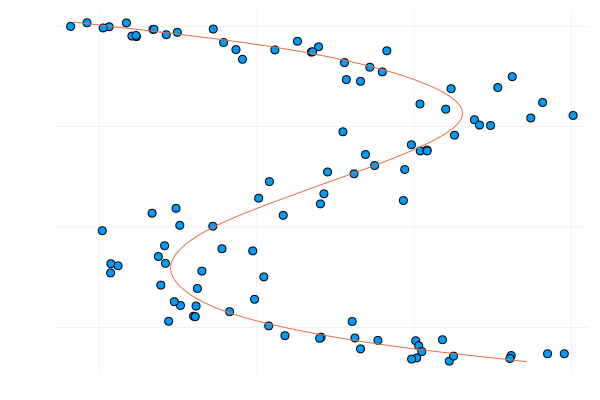

In [33]:
ymeas = lq_estimation_data();
A = [ eye(2)  eye(2); zeros(2,2)  eye(2) ];
B = [ zeros(2,2); eye(2) ];
C = [ eye(2) zeros(2,2) ];
n = size(A,1);
m = size(B,2);
p = size(C,1);
T = 100;
lambda = 1e3;
xest, uest, yest = lqe(A,B,C,ymeas,T,lambda);
scatter(ymeas[1,:], ymeas[2,:], legend = false, axis = false)
plot!( [yt[1] for yt in yest], [yt[2] for yt in yest])

![図17.6](fig17-6.pdf)

図17.6 ノイズのある100個の2次元計測データ（丸点）と$\lambda=1000$に対する推定された軌跡$C \hat{x}_t$（実線）．



この結果が図17.6である．
